In [1]:
# Daniel Bandala @ mar 2022
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ascent algorithm

Read data from txt or csv file separated by tabs

In [2]:
# lee los valores de un archivo de texto
# valores separados por tabulador
data = pd.read_csv("examen_data.txt",sep="\t")
n = data.shape[0]
data.head()

,v1,v2,v3,f
0,-3.540117,29.254710,-4.058648,8.130694
1,-3.203238,21.918892,-3.391914,7.101615
2,-2.833993,16.926479,-2.963484,6.296859
3,-2.632269,17.384516,-3.195253,6.371543
4,-3.376122,27.705983,-4.009433,7.924489


In [3]:
# se seleccionan variables independientes y variable dependiente
x_vectors = ['v1','v2','v3']
X = data[x_vectors]
y = data.f

## Visualize data
Explore statistic information and qualitative parameters from input data

In [4]:
# se obtienen los valores estadisticos de los datos
data.describe()

,v1,v2,v3,f
count,30.000000,30.000000,30.000000,30.000000
mean,-3.069210,22.397017,-3.513504,7.109148
std,0.504776,6.119909,0.473266,0.930389
min,-3.909970,11.632020,-4.396424,5.292154
25%,-3.475607,17.013446,-3.804686,6.310697
50%,-3.114152,22.889375,-3.514091,7.244891
75%,-2.660314,26.877605,-3.204648,7.813024
max,-2.111565,34.866223,-2.631293,8.833959


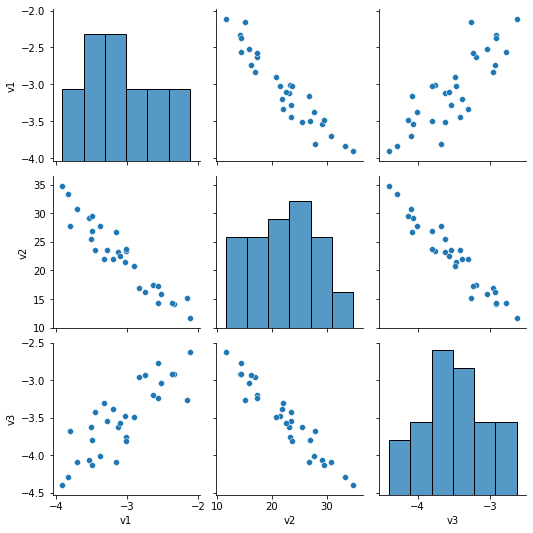

In [5]:
# se grafican las relaciones de distribuciones entre las variables independientes
sns.pairplot(X)

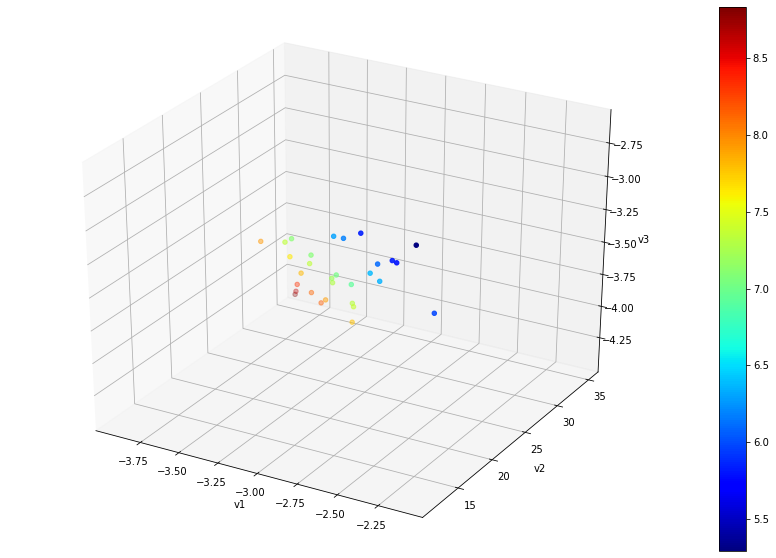

In [6]:
# se grafican los datos de entrada
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X.v1,X.v2,X.v3,c=y,cmap="jet")
fig.colorbar(img)
ax.set_xlabel(x_vectors[0])
ax.set_ylabel(x_vectors[1])
ax.set_zlabel(x_vectors[2])
plt.show()

Text(0, 0.5, 'f')

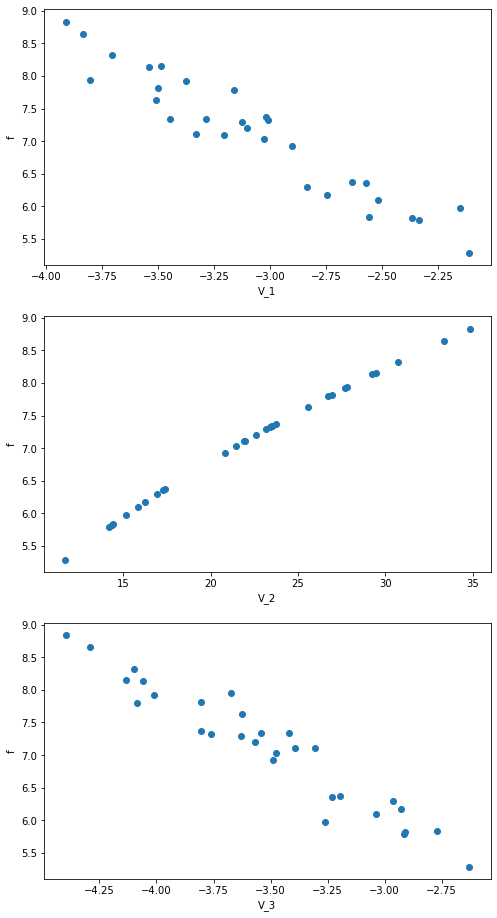

In [7]:
fig, axs = plt.subplots(3,figsize=(8,16))
axs[0].scatter(X.v1, y)
axs[0].set_xlabel("V_1")
axs[0].set_ylabel("f")
axs[1].scatter(X.v2, y)
axs[1].set_xlabel("V_2")
axs[1].set_ylabel("f")
axs[2].scatter(X.v3, y)
axs[2].set_xlabel("V_3")
axs[2].set_ylabel("f")

# Fit model using naive ascent algorithm

## Functions to fit model using chramers theorem in the minimax sense

In [8]:
def fitModel(X,y,inner_set):
    # get inner set length
    m = len(inner_set)
    # initialize system matrix
    A_aux = np.zeros((m,m-1))
    # initialize independent parameters vector for inner set
    y_inner = np.zeros(m)
    # model parameters
    for i in range(m):
        # index from inner set
        idx = inner_set[i]
        # proposed model monomions
        x1 = 1
        x2 = X.v1[idx]
        x3 = X.v2[idx]
        x4 = X.v3[idx]
        x5 = X.v1[idx]*X.v2[idx]
        x6 = X.v2[idx]*X.v3[idx]
        x7 = X.v1[idx]*X.v3[idx]
        x8 = X.v1[idx]*X.v2[idx]*X.v3[idx]
        # insert row vector into auxiliar matrix
        A_aux[i] = np.array([x1,x2,x3,x4,x5,x6,x7,x8])
        y_inner[i] = y[idx]
    # error signs
    sigm = np.zeros(m)
    for i in range(m):
        # remove ith row from system matrix
        X_i = np.delete(A_aux,(i),axis=0)
        # get sign of determinant of x_i
        sgn_det = int(np.sign(np.linalg.det(X_i)))
        sigm[i] = (-1)**(i+2)*sgn_det
    # solve system
    A_inner = np.c_[sigm,A_aux]
    inner_sol = np.linalg.solve(A_inner,y_inner)
    # get maximum absolute error of inner set
    inner_error = np.abs(inner_sol[0])
    # get best approximation coeficients in minimax sense
    inner_coefs = [inner_sol[i] for i in range(1,inner_sol.size)]
    return inner_coefs,inner_error

In [9]:
def outerEvaluate(X,y,inner_set,coefs):
    # get size of data
    n = X.shape[0]
    # initialize errors register
    outer_errors = np.zeros(0)
    for i in range(n):
        # if element is in inner set skip it
        if i in inner_set:
            outer_errors = np.append(outer_errors,0)
            continue
        x1 = 1
        x2 = X.v1[i]
        x3 = X.v2[i]
        x4 = X.v3[i]
        x5 = X.v1[i]*X.v2[i]
        x6 = X.v2[i]*X.v3[i]
        x7 = X.v1[i]*X.v3[i]
        x8 = X.v1[i]*X.v2[i]*X.v3[i]
        # get prediction made by trained model on outer set
        y_pred = coefs[0]*x1+coefs[1]*x2+coefs[2]*x3+coefs[3]*x4+coefs[4]*x5+coefs[5]*x6+coefs[6]*x7+coefs[7]*x8
        # append error beteween real and predicted values
        outer_errors = np.append(outer_errors,np.abs(y[i]-y_pred))
    # return max error and index of outer set
    return np.argmax(outer_errors),np.max(outer_errors)

In [10]:
def ascentAlgorithm(X,y,monomions,max_iterations=4000):
    m = monomions+1
    # error record variables
    inner_error_pts = np.empty(0)
    outer_error_pts = np.empty(0)
    # select initial inner set
    sel_step = int(n/m)
    X_inner = np.empty(0)
    for i in range(len(X[x_vectors[0]])):
        # select equidistant input elements
        if i%sel_step==0:
            X_inner = np.append(X_inner,[i])
        if X_inner.size>=m:
            break
    # start ascent algorithm
    for i in range(max_iterations):
        # fit model to first inner set
        inner_coefs,inner_error = fitModel(X,y,X_inner)
        # evaluate model in outer set
        k,outer_error = outerEvaluate(X,y,X_inner,inner_coefs)
        # save errors points
        inner_error_pts = np.append(inner_error_pts,inner_error)
        outer_error_pts = np.append(outer_error_pts,outer_error)
        # if inner error is equal or greater than outer error stop
        if outer_error<=inner_error:
            break
        # swap tuples
        for i in range(m):
            # copy and change ith inner set element
            new_inner_set = X_inner.copy()
            new_inner_set[i] = k
            # fit model to first inner set
            new_inner_coefs,new_inner_error = fitModel(X,y,new_inner_set)
            # evaluate model in outer set
            new_k,new_outer_error = outerEvaluate(X,y,new_inner_set,new_inner_coefs)
            if (new_inner_error>inner_error):
                break
        # set new inner set for next iteration
        X_inner = new_inner_set.copy()
    return inner_coefs,inner_error_pts,outer_error_pts

## Use functions to fit proposed model

In [11]:
coefs,inner_error,outer_error = ascentAlgorithm(X,y,8)

In [12]:
print("Best coefficients: ",coefs)

Best coefficients:  [1.29528906577616, -3981.106656437051, 3980.8359583354095, 3980.0768290284436, 0.02100978818898676, 0.02087084924364672, -7961.242247041274, 0.0030388723494105176]


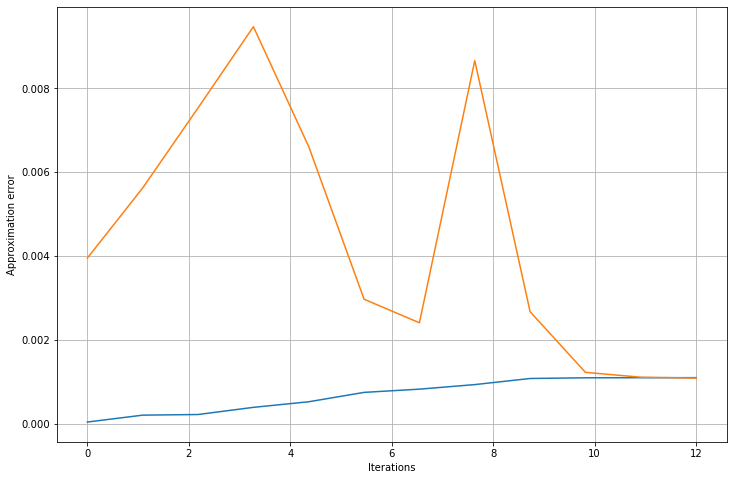

In [13]:
# graph inner and outer set max errors
n_pts = inner_error.size
n_axis = np.linspace(0,n_pts,n_pts)
plt.figure(figsize=(12,8))
plt.plot(n_axis,inner_error)
plt.plot(n_axis,outer_error)
plt.ylabel("Approximation error")
plt.xlabel("Iterations")
plt.grid()